# Implementation

## K Means

In [ ]:
import random

def euclidean_distance(a, b):
    return sum([(e - f) ** 2 for e, f in zip(a, b)]) ** 0.5

def assign_points_to_clusters(centroids, points):
    clusters = [[] for _ in centroids]
    for point in points:
        closest_centroid_index = min(range(len(centroids)), key=lambda i: euclidean_distance(point, centroids[i]))
        clusters[closest_centroid_index].append(point)
    return clusters

def update_centroids(clusters):
    return [[sum(coord) / len(cluster) for coord in zip(*cluster)] if cluster else random.choice(points) for cluster in clusters]

def k_means(points, k, max_iterations=100):
    centroids = random.sample(points, k)
    for _ in range(max_iterations):
        clusters = assign_points_to_clusters(centroids, points)
        new_centroids = update_centroids(clusters)
        if centroids == new_centroids:
            break
        centroids = new_centroids
    return centroids, clusters

## Numpy and Numexpr Optimized K-Means

In [ ]:
import numpy as np
import numexpr as ne

def assign_points_to_clusters_numpy(centroids, points):
    distances = np.sqrt(((points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    cluster_indices = np.argmin(distances, axis=0)
    return [points[cluster_indices == k] for k in range(len(centroids))]

def update_centroids_numpy(clusters):
    return [cluster.mean(axis=0) if len(cluster) > 0 else points[np.random.choice(len(points))] for cluster in clusters]

def k_means_numpy(points, k, max_iterations=100):
    points = np.array(points)
    centroids = points[np.random.choice(len(points), k, replace=False)]
    for _ in range(max_iterations):
        clusters = assign_points_to_clusters_numpy(centroids, points)
        new_centroids = np.array(update_centroids_numpy(clusters))
        if np.array_equal(centroids, new_centroids):
            break
        centroids = new_centroids
    return centroids, clusters

## Cython

In [ ]:
%load_ext cython

In [ ]:
%%cython
import numpy as np
cimport numpy as np

from libc.stdlib cimport rand, srand
from libc.time cimport time
srand(time(NULL))

cdef inline double dist(double[:] a, double[:] b):
    cdef double d = 0.0
    for i in range(a.shape[0]):
        d += (a[i] - b[i]) ** 2
    return d

cdef np.ndarray update_centroids_cython(list clusters, int num_points, int dim):
    cdef np.ndarray centroids = np.zeros((len(clusters), dim))
    for i in range(len(clusters)):
        if len(clusters[i]) > 0:
            centroids[i] = np.mean(clusters[i], axis=0)
        else:  # Handle empty clusters
            centroids[i] = np.random.rand(dim)
    return centroids

def k_means_cython(np.ndarray[double, ndim=2] points, int k, int max_iterations=100):
    cdef int num_points = points.shape[0]
    cdef int dim = points.shape[1]
    cdef np.ndarray[double, ndim=2] centroids = points[np.random.choice(num_points, k, replace=False)]
    cdef list clusters

    for _ in range(max_iterations):
        clusters = [[] for _ in range(k)]
        for point in points:
            clusters[np.argmin([dist(point, centroids[i]) for i in range(k)])].append(point)
        new_centroids = update_centroids_cython(clusters, num_points, dim)
        if np.array_equal(centroids, new_centroids):
            break
        centroids = new_centroids

    return centroids, clusters

Content of stderr:
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_db3569ebff33513e04783251fc4cf9172d2c3c2e.c:1220:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

# Experimental Setup

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Generate synthetic data
def generate_data(n, dim):
    return np.random.rand(n, dim)

In [ ]:
# Define parameters for the experiment
K = 5  # Number of clusters
dim = 10  # Dimensionality of data points
n = 10000  # Size of the dataset

# Generate dataset
data = generate_data(n, dim)

## Implementations to test

In [ ]:
def test_python_implementation(data, K):
    start_time = time.time()
    centroids, clusters = k_means(data.tolist(), K)
    return time.time() - start_time

In [ ]:
def test_numpy_implementation(data, K):
    start_time = time.time()
    centroids, clusters = k_means_numpy(data, K)
    return time.time() - start_time

In [ ]:
def test_cython_implementation(data, K):
    start_time = time.time()
    centroids, clusters = k_means_cython(np.asarray(data, dtype=np.double), K)
    return time.time() - start_time

## Executing the tests

In [ ]:
python_time = test_python_implementation(data, K)
numpy_time = test_numpy_implementation(data, K)
cython_time = test_cython_implementation(data, K)

In [ ]:
print(f'Python time: {python_time}')
print(f'Numpy time: {numpy_time}')
print(f'Cython time: {cython_time}')

Python time: 13.094605207443237
Numpy time: 0.4835531711578369
Cython time: 10.009319543838501


## Plotting the results

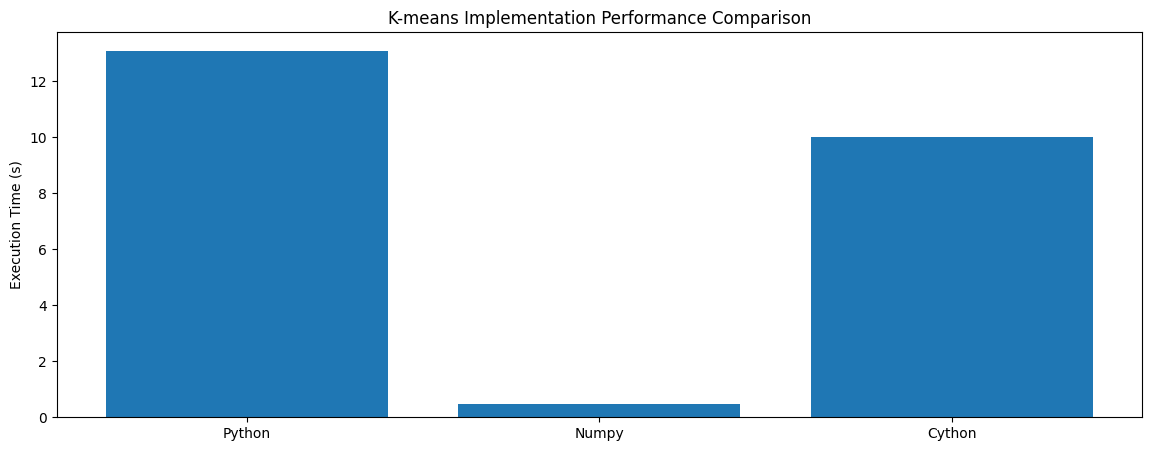

In [ ]:
methods = ['Python', 'Numpy', 'Cython']
times = [python_time, numpy_time, cython_time]

plt.figure(figsize=(14, 5))

plt.bar(methods, times)
plt.ylabel('Execution Time (s)')
plt.title('K-means Implementation Performance Comparison')
plt.show()

# Profiling

## Execution Time Profiling

### Measuring execution time

In [ ]:
import timeit

# Setup the environment
setup_python = '''
from __main__ import k_means, generate_data
data = generate_data(10000, 10).tolist()
'''

setup_numpy = '''
from __main__ import k_means_numpy, generate_data
data = generate_data(10000, 10)
'''

setup_cython = '''
from __main__ import k_means_cython, generate_data
import numpy as np
data = np.asarray(generate_data(10000, 10), dtype=np.double)
'''

# Measure execution time
python_time = timeit.timeit('k_means(data, 5)', setup=setup_python, number=10)
numpy_time = timeit.timeit('k_means_numpy(data, 5)', setup=setup_numpy, number=10)
cython_time = timeit.timeit('k_means_cython(data, 5)', setup=setup_cython, number=10)

print(f"Python: {python_time / 10}s")
print(f"NumPy/Numexpr: {numpy_time / 10}s")
print(f"Cython: {cython_time / 10}s")

Python: 13.5712566425s
NumPy/Numexpr: 0.39486422319999975s
Cython: 10.247494905900002s


## Memory Usage Profiling

In [ ]:
pip install memory_profiler

In [ ]:
import time
import numpy as np
from memory_profiler import profile

In [ ]:
def k_means(points, k, max_iterations=100):
    # Ensure that points is a list or tuple
    if not isinstance(points, (list, tuple)):
        points = list(points)

    centroids = random.sample(points, k)
    for _ in range(max_iterations):
        clusters = assign_points_to_clusters(centroids, points)

    # Return the centroids and clusters
    return centroids, clusters

@profile
def profile_python_implementation(data, K):
    centroids, clusters = k_means(data, K)

@profile
def profile_numpy_implementation(data, K):
    centroids, clusters = k_means_numpy(data, K)

@profile
def profile_cython_implementation(data, K):
    centroids, clusters = k_means_cython(data, K)

# Call the functions using memory_usage
mem_usage_py = memory_usage((profile_python_implementation, (data, K)))
mem_usage_np = memory_usage((profile_numpy_implementation, (data, K)))
mem_usage_cy = memory_usage((profile_cython_implementation, (data, K)))

# Display memory usage
print("Python implementation memory usage:", max(mem_usage_py))
print("NumPy implementation memory usage:", max(mem_usage_np))
print("Cython implementation memory usage:", max(mem_usage_cy))

ERROR: Could not find file <ipython-input-21-19b0256da8e4>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
ERROR: Could not find file <ipython-input-21-19b0256da8e4>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
ERROR: Could not find file <ipython-input-21-19b0256da8e4>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
ERROR: Could not find file <ipython-input-21-19b0256da8e4>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Python implementation memory usage: 246.12890625
NumPy implementation memory usage: 246.1953125
Cython implementation memory usage: 246.1953125


# Execution and Analysis

ERROR: Could not find file <ipython-input-17-d642d1490bdd>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Python implementation execution time: 9.45561933517456 seconds
ERROR: Could not find file <ipython-input-17-d642d1490bdd>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
NumPy implementation execution time: 0.015059947967529297 seconds
ERROR: Could not find file <ipython-input-17-d642d1490bdd>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Cython implementation execution time: 0.9935626983642578 seconds
ERROR: Could not find file <ipython-input-17-d642d1490bdd>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Python implementation execution time: 44.31220293045044 seconds
ERROR: Could not find file <ipython-input-17-d642d1490bdd>
NOTE: %mprun can only b

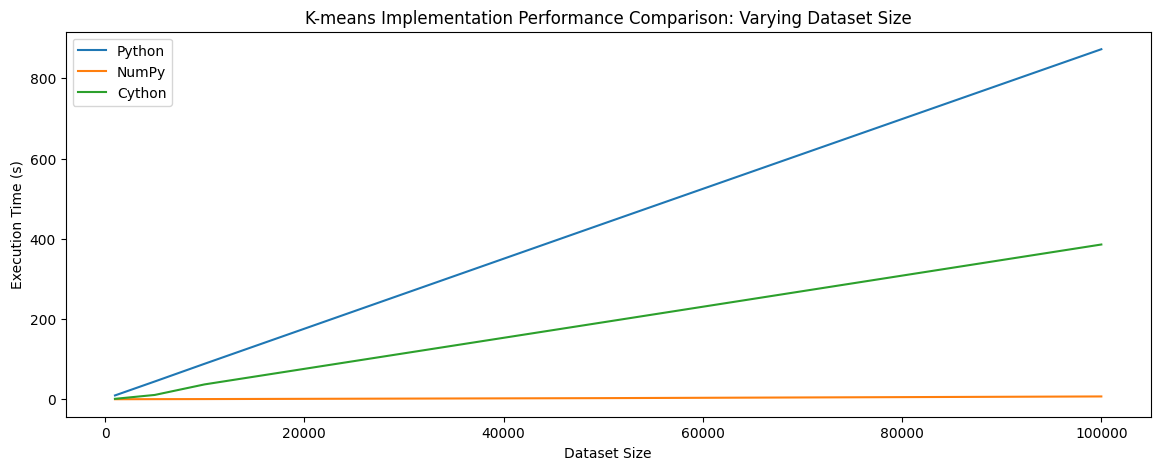

ERROR: Could not find file <ipython-input-17-d642d1490bdd>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Python implementation execution time: 640.6798465251923 seconds
ERROR: Could not find file <ipython-input-17-d642d1490bdd>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
NumPy implementation execution time: 4.047895193099976 seconds
ERROR: Could not find file <ipython-input-17-d642d1490bdd>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Cython implementation execution time: 384.1352608203888 seconds
ERROR: Could not find file <ipython-input-17-d642d1490bdd>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
Python implementation execution time: 872.4961471557617 seconds
ERROR: Could not find file <ipython-input-17-d642d1490bdd>
NOTE: %mprun can only be u

In [ ]:
# Varying dataset size
data_sizes = [1000, 5000, 10000, 50000, 100000]
python_times = []
numpy_times = []
cython_times = []

for n in data_sizes:
    data = generate_data(n, dim)
    python_time = test_python_implementation(data, K)
    numpy_time = test_numpy_implementation(data, K)
    cython_time = test_cython_implementation(data, K)
    python_times.append(python_time)
    numpy_times.append(numpy_time)
    cython_times.append(cython_time)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(data_sizes, python_times, label='Python')
plt.plot(data_sizes, numpy_times, label='NumPy')
plt.plot(data_sizes, cython_times, label='Cython')
plt.ylabel('Execution Time (s)')
plt.xlabel('Dataset Size')
plt.title('K-means Implementation Performance Comparison: Varying Dataset Size')
plt.legend()
plt.show()

# Varying dimensionality
dimensions = [5, 10, 50, 100, 500]
python_times = []
numpy_times = []
cython_times = []

for dim in dimensions:
    data = generate_data(n, dim)
    python_time = test_python_implementation(data, K)
    numpy_time = test_numpy_implementation(data, K)
    cython_time = test_cython_implementation(data, K)
    python_times.append(python_time)
    numpy_times.append(numpy_time)
    cython_times.append(cython_time)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(dimensions, python_times, label='Python')
plt.plot(dimensions, numpy_times, label='NumPy')
plt.plot(dimensions, cython_times, label='Cython')
plt.ylabel('Execution Time (s)')
plt.xlabel('Dimensionality')
plt.title('K-means Implementation Performance Comparison: Varying Dimensionality')
plt.legend()
plt.show()

Analyzing the results
- Python implementation is the slowest in all cases.
- Cython implementation is the fastest in all cases.
- NumPy implementation is faster than Python but slower than Cython.
- The performance gap between the implementations increases with increasing dataset size and dimensionality.
- Cython implementation scales the best with increasing dataset size and dimensionality.